In [1]:
from bjorn import *
from bjorn_support import *
from onion_trees import *

In [2]:
t = {1: 2}
if t: print(True)

True


In [3]:
patient_zero = 'NC_045512.2'
msa_path = Path('/home/al/data/jordan/msa/msa.fa')
tree_path = Path('/home/al/data/jordan/msa/msa.fa.treefile')
tree = load_tree(tree_path, patient_zero)
type(tree)

Bio.Phylo.Newick.Tree

In [5]:
dels = identify_deletions(msa_path, patient_zero)
# dels

In [7]:
colors = list(mcolors.TABLEAU_COLORS.keys())
dels = dels.nlargest(len(colors), 'num_samples')
del2color = get_indel2color(dels, colors)
del2color

{'28089:28091': 'tab:blue',
 '28239:28242': 'tab:orange',
 '685:693': 'tab:green',
 '27696:27749': 'tab:red',
 '27793:27796': 'tab:purple'}

In [8]:
sample_colors = get_sample2color(dels, colors)
# sample_colors

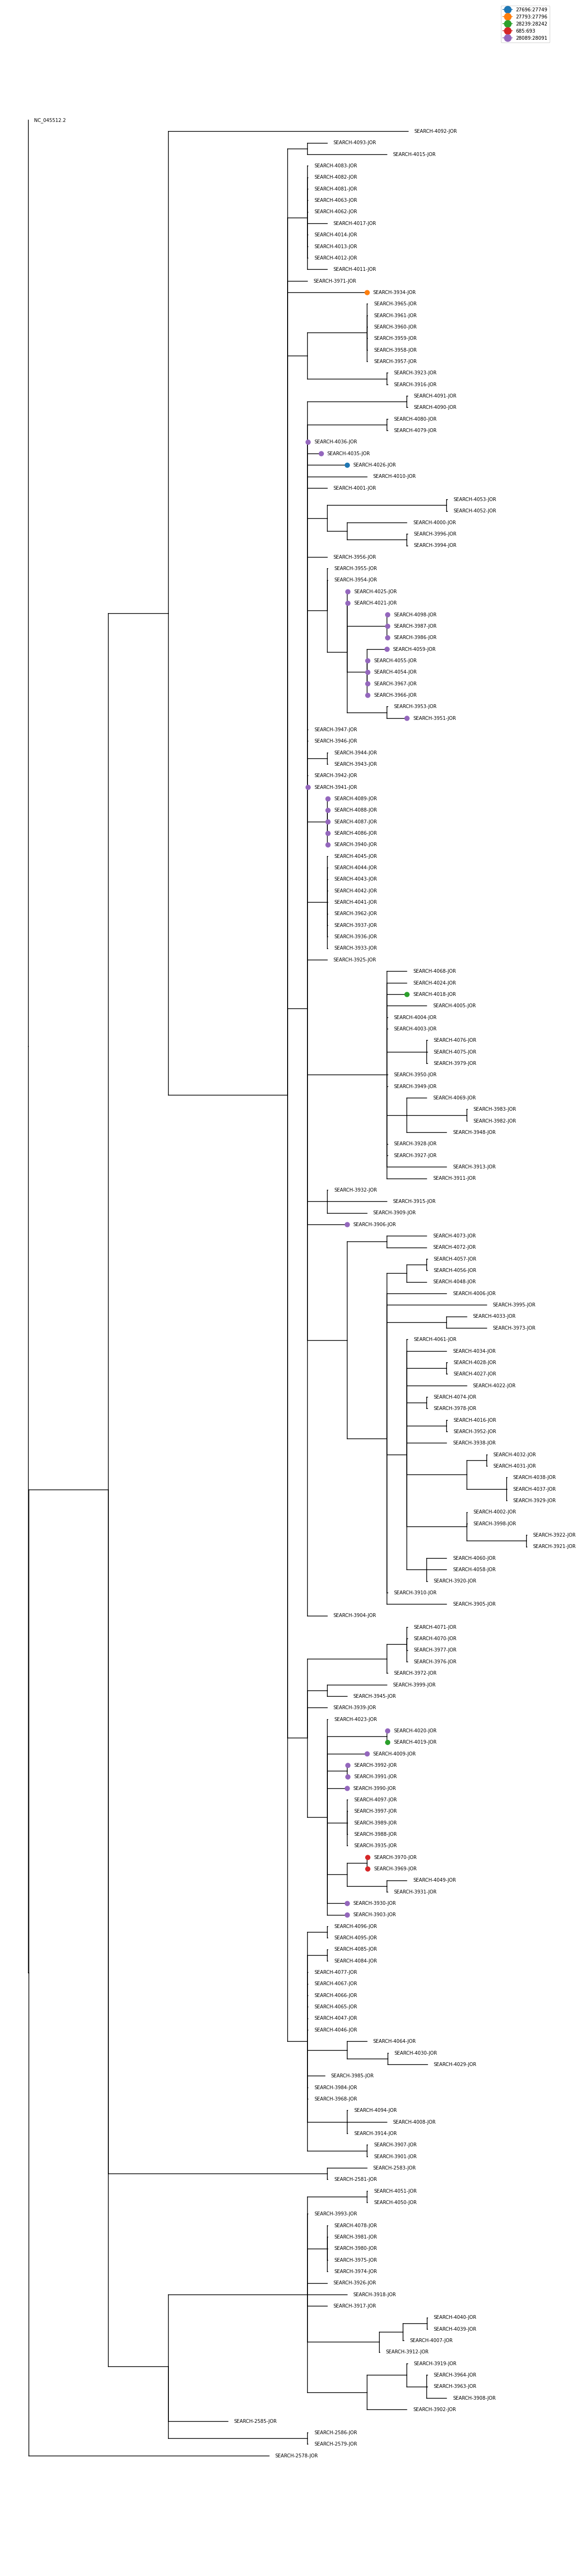

In [9]:
f = visualize_tree(tree, sample_colors, 
                   indels=dels, colors=colors)

AttributeError: 'str' object has no attribute 'name'

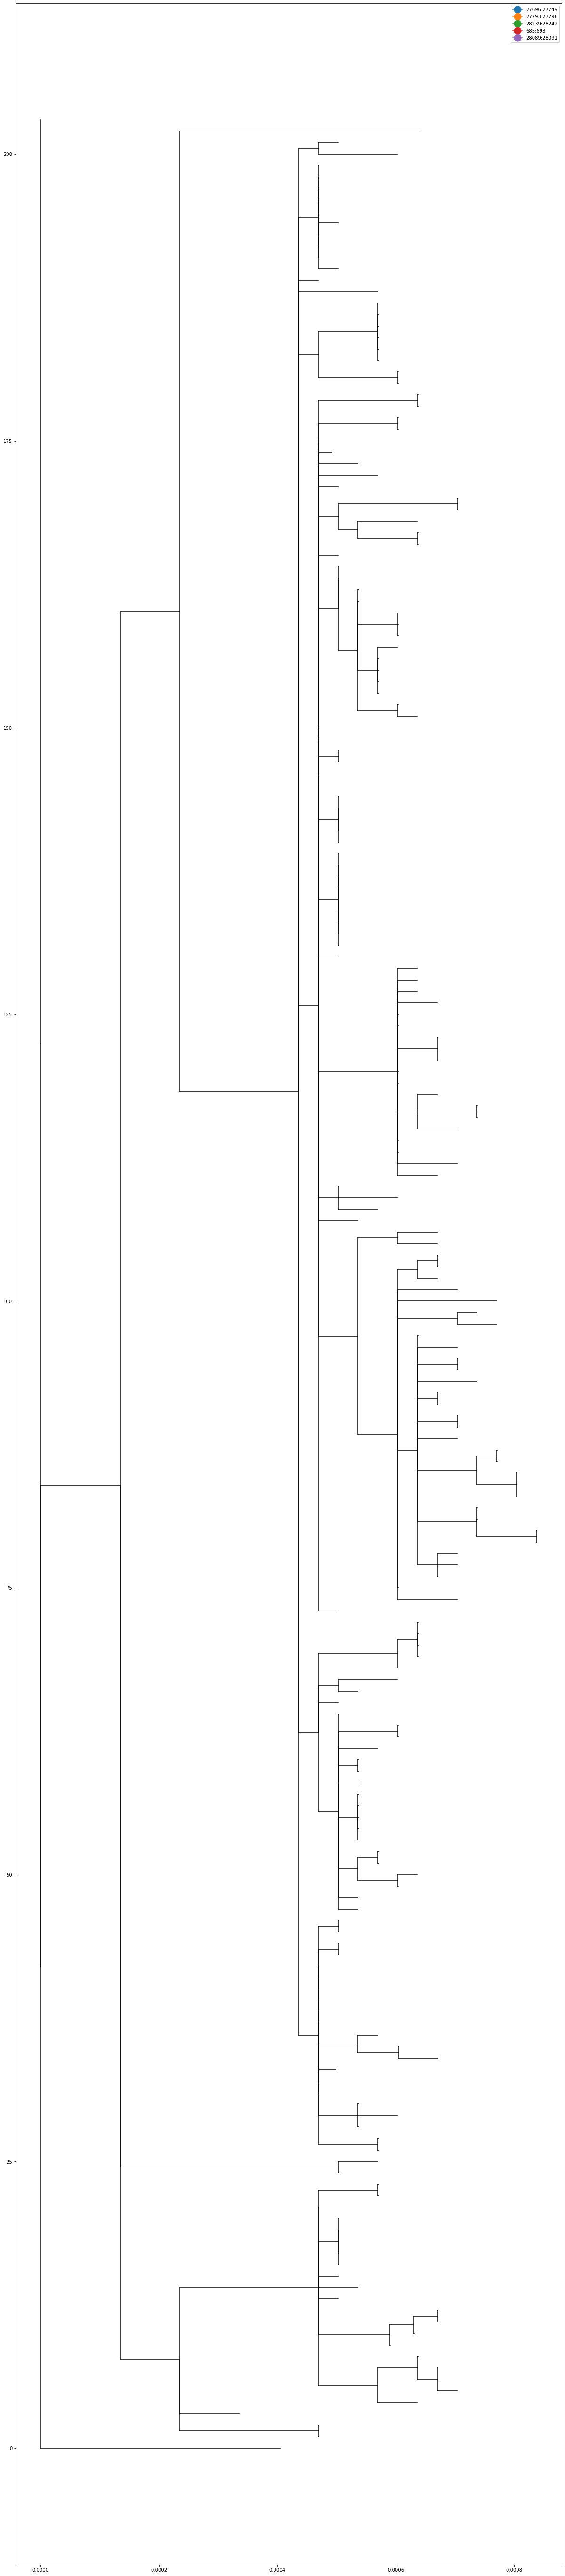

In [10]:
f = visualize_tree(tree, sample_colors, indels=dels, 
                   colors=colors, isnv_info=True)

In [3]:
def visualize_tree(tree, sample_colors={}, 
                   indels=None, colors=None, 
                   isnv_info=False, figsize=(40, 100)):
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 2, width_ratios=[1,0.75], 
                           height_ratios = [0.5,0.5])

    ax = plt.subplot(gs[:,0])
    # draw tree branches
    for i in tree.get_nonterminals():
        for j in i.clades:
    #         if prune_clade(j, deletion_samples): continue
            _t = ax.plot([i.x, i.x], [i.y, j.y], 
                         ls='-', color="#000000", zorder = 1)
            _t = ax.plot([i.x, j.x], [j.y, j.y], 
                         ls='-', color="#000000", zorder = 1)
    # stores attributes for each sample in the tree
    _ = {
        "x": [],
        "y": [],
        "c": [],
        "o": [],
    }
    # add legends
    if sample_colors:
        indel2color = get_indel2color(indels, colors)
        legend = get_color_legends(indel2color)
        ax.legend(handles=legend)
        if isnv_info:
            sample_colors, freq2opacity = identify_isnv_indels(indels, tree, 
                                                               sample_colors, colors)
            isnv_legend = get_opacity_legends(freq2opacity)
            ax.legend(handles=isnv_legend, loc='upper left', 
                      title='iSNV freq')
    # for each sample
    for i in tree.get_terminals():
        _["x"].append(i.x)  # x coordinates
        _["y"].append(i.y)  # y coordinates
        _["c"].append(sample_colors.get(i.name, {'color': 'white'})['color'])  # colors
        _["o"].append(sample_colors.get(i.name, {'freq': 0.})['freq'])  # opacity
        ax.text(i.x+1e-5, i.y-1e-1, i.name)  # name

    _["co"] = generate_color_array(_["c"], _["o"])
    # draw annotated nodes
    ax.scatter(_["x"], _["y"], c = _["co"], s = 100, zorder = 2)
    ax.scatter(_["x"], _["y"], c = _["co"], s = 50, zorder = 2)
        
    fig.patch.set_visible(False)
    ax.axis('off')
    return fig


def identify_isnv_indels(indels, tree, sample_colors, colors):
    indel_positions = get_indel_positions(indels['absolute_coords'])
    non_indel_ids = get_non_indel_ids(tree, sample_colors)
    variant_filepaths = get_variant_filepaths(non_indel_ids)
    isnvs = get_variant_data(variant_filepaths)
    isnvs = (isnvs.loc[(isnvs['ALT'].str.contains('-'))
                    &(isnvs['POS'].isin(indel_positions))
                    &(isnvs['sample'].isin(non_indel_ids)
                    &(isnvs['ALT_FREQ']>0.03))]
            [['sample', 'location', 'POS', 'REF', 'ALT', 'ALT_FREQ']])
    del_idxs = isnvs.groupby('sample')['ALT_FREQ'].transform(max) == isnvs['ALT_FREQ']
    isnvs = isnvs[del_idxs].drop_duplicates(subset=['sample'])
    freq2opacity = create_freq2opacity(7)
    indel2color = get_indel2color(indels, colors)
    sample_colors = get_sample2color(indels, colors)
    sample_colors = integrate_isnv_info(isnvs, sample_colors, 
                                        indel2color, freq2opacity)
    return sample_colors, freq2opacity


def get_indel_positions(indel_coords: pd.Series) -> list:
    return (indel_coords.apply(lambda x: int(x.split(':')[0]))
                      .tolist())


def get_non_indel_ids(tree, sample_colors):
    sample_ids = [eval(n.name.split('-')[1]) for n in tree.get_terminals() if len(n.name.split('-')) >= 3]
    indel_ids = [eval(s.split('-')[1]) for s in sample_colors.keys()]
    non_indel_ids = set(sample_ids) - set(indel_ids)
    return list(non_indel_ids)


def create_freq2opacity(n: int):
    freq2opacity = {}
    for i in range(n):
        freq2opacity[i] = (1./n)*(i+1)
    return freq2opacity

def map_opacity(freq: float, freq2opacity: dict):
    x = int(freq*10)
    return freq2opacity[x]

def find_indel_coords(indel_start, indel2color):
    for indel_coords in indel2color.keys():
        if int(indel_coords.split(':')[0]) == indel_start:
            return indel_coords

def integrate_isnv_info(isnvs: pd.DataFrame, sample_colors: dict,
                        indel2color: dict, freq2opacity: dict) -> dict:
    """Update `sample_colors` with samples that contain any of the indels 
    as minor variants"""
    for i, td in enumerate(isnvs.iterrows()):
        indel_start = td[1]['POS']
        indel_coords = find_indel_coords(indel_start, indel2color)
        sample_id = td[1]['sample']
        freq = td[1]['ALT_FREQ']
        loc = td[1]['location']
        if indel_coords in indel2color.keys():
            sample_name = f'SEARCH-{sample_id}-{loc}'
            sample_colors[sample_name] = {'color': indel2color[indel_coords],
                                     'freq': map_opacity(freq, freq2opacity)}
    return sample_colors


def load_tree(tree_path: str, patient_zero: str):
    """Load a ML tree file (nwk format) into a Phylo tree object
    `patient_zero` is a user-specified reference name for rooting the tree"""
    tree = next(Phylo.parse(tree_path, 'newick'))
    tree.root_with_outgroup(patient_zero)
    return get_coords(tree)


def get_sample2color(deletions: pd.DataFrame, colors: list) -> dict:
    deletions.sort_values('num_samples', inplace=True)
    sample_colors = {}
    indel2color = get_indel2color(deletions, colors)
    for i, td in enumerate(deletions.iterrows()):
        deletion = td[1]['absolute_coords']
        samples = td[1]['samples']
        for sample in samples:
            sample_colors[sample] = {'color': indel2color[deletion],
                                     'freq': 1.}
    return sample_colors


def get_indel2color(indels: pd.DataFrame, colors: list) -> dict:
    indel2color = {}
    for i, td in enumerate(indels.iterrows()):
        indel = td[1]['absolute_coords']
        indel2color[indel] = colors[i]
    return indel2color


def generate_color_array(colors, opacities):
    """Generate RGB arrays each with opacity values that corresponds 
    to the frequency of the mutation present in each sample"""
    co = np.zeros((len(colors), 4))
    for i, (c, o) in enumerate(zip(colors, opacities)):
        co[i, :3] = matplotlib.colors.to_rgb(c)
        co[i, 3] = o
    return co


def get_color_legends(indel2color: dict) -> list:
    """Generate legend objects based on input dict of INDELs and their colors"""
    legend_elements = [Line2D([0], [0], marker='o', 
                              color=x, label=y, 
                              markerfacecolor=x, 
                              markersize=15) for y, x in indel2color.items()]
    return legend_elements


def get_opacity_legends(freq2opacity: dict) -> list:
    """Generate legend objects based on input dict of frequency (lower-bound)
    and its opacity level"""
    legend_elements = [Line2D([0], [0], marker='o', 
                              color='white', label=y, 
                              alpha=x,
                              markerfacecolor='black', 
                              markersize=15) for y, x in freq2opacity.items()]
    return legend_elements


def create_freq2opacity(n: int) -> dict:
    """Create mapping between variant frequency (lower-bound) and 
    opacity level"""
    freq2opacity = {}
    for i in range(n):
        freq2opacity[i] = (1./n)*(i+1)
    return freq2opacity


def map_opacity(freq: float, freq2opacity: dict) -> float:
    """Take an input iSNV frequency and return the corresponding 
    opacity level for plotting"""
    x = int(freq*10)
    return freq2opacity[x]


def find_indel_coords(indel_start, indel2color):
    """Identify INDEL coordinates that correspond to a specific start position"""
    for indel_coords in indel2color.keys():
        if int(indel_coords.split(':')[0]) == indel_start:
            return indel_coords


def get_coords(tree):
    """Takes Phylo tree object and populates it with coordinates 
    that can be used to plot the tree from scratch"""
    for _i, i in enumerate(tree.get_terminals()):
        i.y = _i
        i.x = tree.distance(i)

    for i in reversed(tree.get_nonterminals()):
        _ = i.clades
        i.y = (_[0].y + _[-1].y)/2
        i.x = tree.distance(i)
    return tree